In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Union

from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field
import requests
from io import BytesIO
from PIL import Image
import numpy as np
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd
import seaborn as sns
import json

import nest_asyncio
nest_asyncio.apply()

from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo, ImageNode
from llama_index.core.schema import ImageNode, NodeWithScore, MetadataMode
from llama_index.postprocessor.cohere_rerank import CohereRerank
from llama_index.core.schema import QueryBundle


import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
claude_mm_default = BasicAnthropicLLM(model='claude-3-5-sonnet-20240620', temperature = 0.0)

In [4]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [5]:
fig_num = 2

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

In [6]:
query_tool = handler.query_engine_tool(metadata_filters=filters)

In [7]:
class Variable(BaseModel):
    """
    A variable is a quantity that is varied across the experimental conditions. It can be numeric, categorical, or both.
    Categories usually map to some visual feature like color, line style, or marker shape.
    Numerica variables usually map to coordinate axes.
    """
    name: str = Field(..., description="The name of the variable")
    categorical: bool = Field(..., description="Whether the variable has categorical axes")
    numeric: bool = Field(..., description="Whether the variable has numeric axes")

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]
    text_discrepancies: list[str] = Field(default_factory=list, description="Any discrepancies between the text information and the image information that we should note when referencing the text in the future (e.g. persistent or occasional mis-references).")

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable in this specific plot. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class Legend(BaseModel):
    """
    A legend is a set of category maps that map the categorical variables to their visual labels for the entire figure. Only include properties that apply to the figure as a whole.
    """
    category_maps: list[CategoryMap] = Field(
        default_factory=list,
        description="The category maps for the legend of the figure."
    )

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    legend: Legend



In [8]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [9]:
response = query_tool(prompt)
nodes = response.raw_output.source_nodes
figure_struct = output_parser.parse(response.content)

In [10]:
nodes

[NodeWithScore(node=TextNode(id_='816f492a-fb49-4eab-8c9c-7c0a71364724', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'Light delivery and imaging', 'experimental_variable_entities': ['light pulse duration', 'wavelength', 'power', 'photocurrent strength', 'light intensity'], 'fig_refs': ['Supplemental Figure 5', 'Figure 2e']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='406f6538-1333-433c-ba38-1dfc674f2352', node_type=None, metadata={}, hash=None)}, text='Light delivery and imaging\n\nPatch-clamp recordings were done with short light pulses to measure photocurrents. Light pulse duration, wavelength, and power were varied depending on the experiment (as describe

In [11]:
# find figure image
for node in nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))
        source_figure_summary = node.node.text

In [12]:
fig_description = f"{figure_struct.name}"
fig_description += f"\n\tLegend: {figure_struct.legend.category_maps}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name} (plot.text_discrepancies: {plot.text_discrepancies})"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 2
	Legend: [CategoryMap(type='color', values={'CheRiff': [0.5, 0.5, 0.5], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [0.5, 0.5, 0.5], '11_10': [0.0, 1.0, 1.0], '12_10': [1.0, 0.0, 1.0], '25_9': [0.0, 1.0, 1.0], '10_10': [1.0, 1.0, 0.0], '15_10': [0.0, 0.0, 1.0], '28_10': [1.0, 0.5, 0.0], '21_10': [0.5, 0.0, 0.5], '3_10': [1.0, 0.0, 0.0]})]
	Panel: a

		Plot: Current traces and cell images (plot.text_discrepancies: [])
			independent_variables=[Variable(name='ChR variant', categorical=True, numeric=False), Variable(name='Time', categorical=False, numeric=True)] dependent_variables=[Variable(name='Current', categorical=False, numeric=True), Variable(name='Fluorescence', categorical=False, numeric=True)]
	Panel: b

		Plot: Photocurrent strength with different wavelength excitation (plot.text_discrepancies: [])
			independent_variables=[Variable(name='ChR variant', categorical=True, numeric=False), Variable(name='Wavelength', categorical=True, numeric=True)] dependent_variables=[Variable(

In [174]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper.
You will also be provided with excerpts from the text of the paper that are relevant.
Your job is to write a new figure caption that consolidates information across all of the sources.
Retain ALL DETAIL, DO NOT SUMMARIZE. This is an orginazational task not a summarization task.
Double check that any references (including in figure captions) are correct based on your visual inspection of the figure.
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the figure experiments:
{fig_description}

Retrieved text information regarding the figure from the paper text:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=3)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.NONE) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(fig_description=fig_description, context=context).replace("{", "{{").replace("}", "}}")
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)

In [175]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)
details_text = response.content[0].text
print(details_text)

Figure 2. Model-predicted ChRs exhibit diverse functional properties exceeding parental variants.

(a) Representative current traces after 0.5 s light exposure for select ChR variants with corresponding expression and localization in HEK cells. Vertical colored scale bar: 500 pA; horizontal scale bar: 250 ms. Variant colors are consistent throughout panels.

(b) Peak and steady-state photocurrent measurements with different wavelengths in HEK cells (n = 4–8 cells, see Dataset 2). Light conditions: 397 nm at 1.5 mW mm−2, 481 nm at 2.3 mW mm−2, 546 nm at 2.8 mW mm−2, and 640 nm at 2.2 mW mm−2.

(c) Off-kinetics decay rate (τoff) following 1 ms exposure to 481 nm light at 2.3 mW mm−2 (n = 4–8 cells, see Dataset 2). Parent ChRs highlighted in light gray. Inset: Representative current traces with 1 ms light exposure for select ChRs. ChR_21_10 turns off rapidly, ChR_25_9 and ChR_11_10 turn off more slowly, and ChR_15_10 shows little decrease in photocurrent 0.5 s post-exposure.

(d) Waveleng

In [21]:
# select panel d (only one plot in panel)
panel = figure_struct.panels[3]
plot = panel.plots[0]
exp = plot.experiments[0]

In [22]:
class BoundingBox(BaseModel):
    left_x: float = Field(default = 0.0, description="The x-coordinate of the left side of the bounding box in the range 0.0 to 1.0")
    upper_y: float = Field(default = 0.0, description="The y-coordinate of the top side of the bounding box in the range 0.0 to 1.0")
    right_x: float = Field(default = 1.0, description="The x-coordinate of the right side of the bounding box in the range 0.0 to 1.0")
    lower_y: float = Field(default = 1.0, description="The y-coordinate of the bottom side of the bounding box")

In [23]:
output_parser = PydanticOutputParser(output_cls=BoundingBox)

In [24]:
PLOT_CROP_PROMPT = """
Provide a bounding box for panel {panel_name} (plot title/description: {plot_name}) in the provided figure. 
Be liberal with padding, we'd rather have extra that lose part of the panel."""

prompt = PromptTemplate(
    PLOT_CROP_PROMPT.format(panel_name=panel.name, plot_name=plot.name), 
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)

In [25]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure]
)

In [26]:
bbox = output_parser.parse(response.content[0].text)

In [27]:
padding = 0.1
bbox_cropped = BoundingBox()
bbox_cropped.left_x = np.max([0, bbox.left_x - padding])
bbox_cropped.upper_y = np.max([0, bbox.upper_y - padding])
bbox_cropped.right_x = np.min([1, bbox.right_x + padding])
bbox_cropped.lower_y = np.min([1, bbox.lower_y + padding])
bbox_cropped

BoundingBox(left_x=0.0, upper_y=0.5800000000000001, right_x=0.43000000000000005, lower_y=1.0)

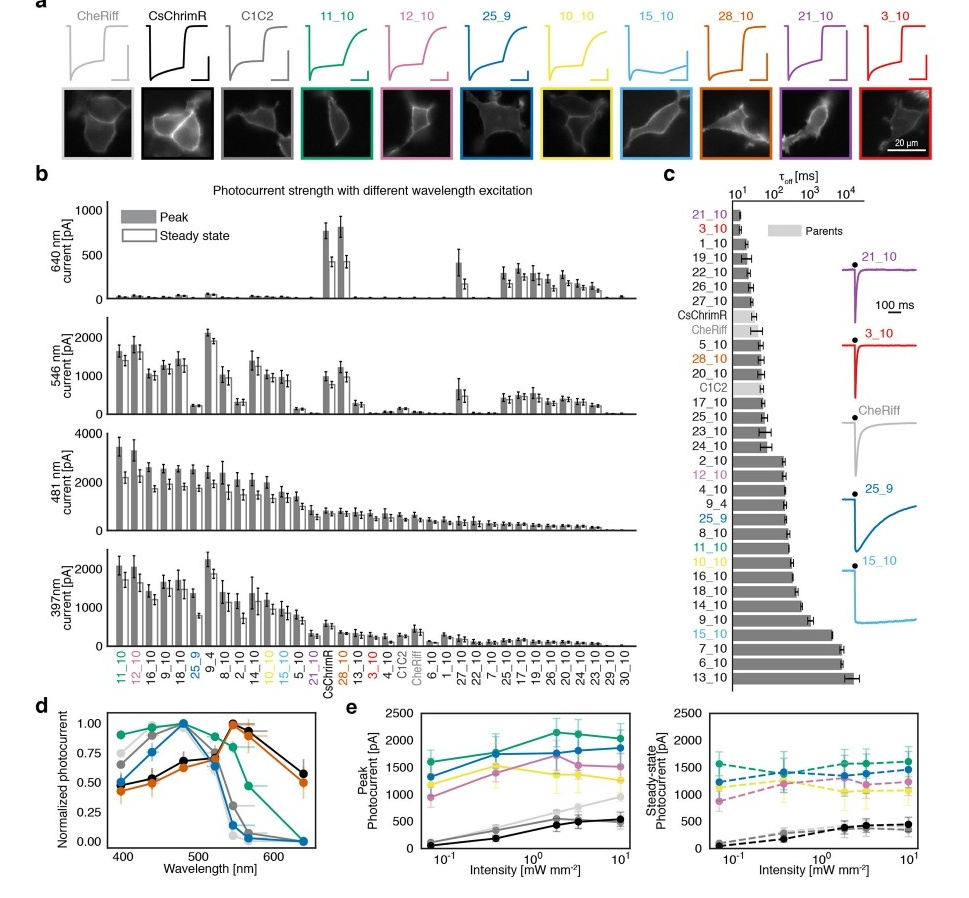

In [28]:
source_figure

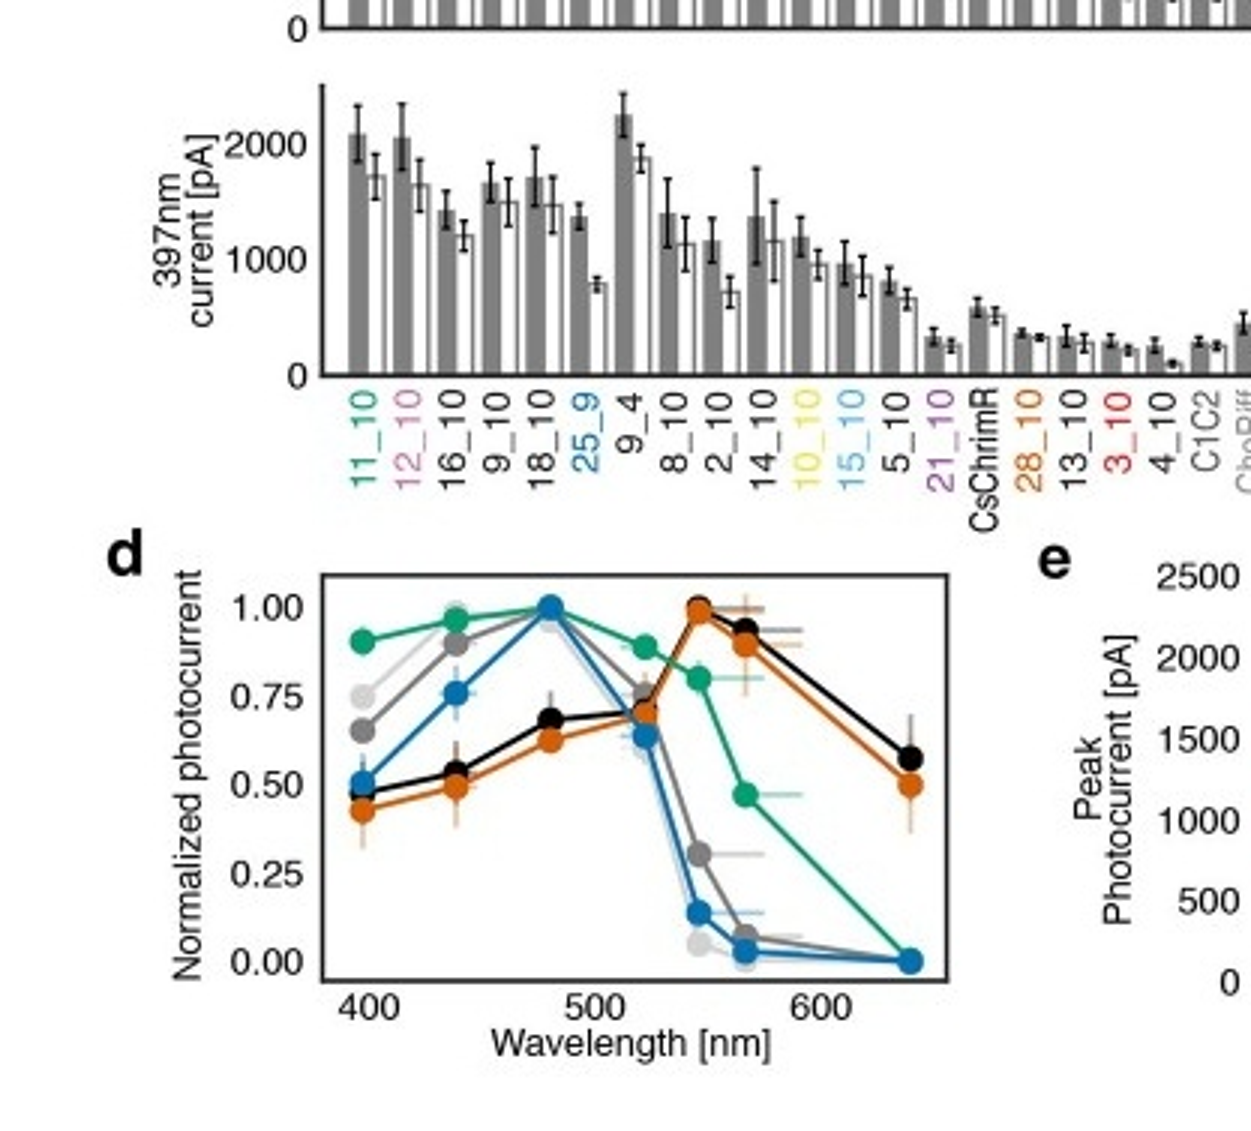

In [29]:
# use pillow to crop the image
fig_size = source_figure.size
bbox_px_vals = [bbox_cropped.left_x*fig_size[0], bbox_cropped.upper_y*fig_size[1], bbox_cropped.right_x*fig_size[0], bbox_cropped.lower_y*fig_size[1]]

# Crop the image using the extracted coordinates
cropped_img = source_figure.crop(bbox_px_vals)
# resize the image to closer to original size
cropped_img_size = cropped_img.size
cropped_img_zoomed = cropped_img.resize([pix_count * 3 for pix_count in cropped_img_size])
cropped_img_zoomed.save("cropped_img.png")
cropped_img = Image.open("cropped_img.png")
cropped_img

In [30]:
# make image node from cropped image
from plotreader.utils import image_to_base64

# convert PIL image to b64 encoded string
cropped_img_b64 = image_to_base64(cropped_img)

cropped_img_node = ImageNode(
    image=cropped_img_b64,
    image_url=None,
    metadata={
        "fig_refs": [f"Figure {fig_num}{panel.name}"],
    }
)

In [31]:
nodes.append(cropped_img_node)

In [32]:
fig_filter =  MetadataFilter(
    key="fig_refs", 
    value=f'Figure {fig_num}',
    operator=FilterOperator.TEXT_MATCH_LIST
)

entity_filters = [
    MetadataFilter(
        key="experimental_variable_entities",
        value = iv.name,
        operator=FilterOperator.TEXT_MATCH_LIST
    ) for iv in plot.experiments[0].independent_variables
]

# entity_filters += [
#     MetadataFilter(
#         key="experimental_variable_entities",
#         value = dv.name,
#         operator=FilterOperator.TEXT_MATCH_LIST
#     ) for dv in plot.experiments[0].dependent_variables
# ]

filters = MetadataFilters(
    filters= [fig_filter] + entity_filters,
    condition=FilterCondition.OR
)

retriever = handler.vector_index().as_retriever(
    similarity_top_k=10,
    filters=filters
)

In [39]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper and information extracted from the text of that paper.
Focus on panel {panel_name}, plot {plot_name}.
Are there any major discrepancies between the text and the image - e.g. the text is not referencing the correct panel or plot or label?
Be as nit-picky as possible. Do not miss any mistakes
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

nodes = retriever.retrieve(FIGURE_SUMMARY_PROMPT)
text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=10)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)

In [40]:
response = claude_mm_default.message(
    full_prompt_formatted,
    images = [source_figure]
)
details_text = response.content[0].text
print(details_text)

Based on my analysis of panel d in Figure 2 and the provided text information, there do not appear to be any major discrepancies between the text and the image. The text accurately describes the plot of normalized photocurrent vs wavelength shown in panel d. Specifically:

1. The text mentions that ChR_28_10 has a red-shifted spectrum matching CsChrimR, which is consistent with the red line in the plot.

2. It states that ChR_11_10 has a broad activation spectrum with similar current strength from 400-546 nm, which matches the purple line showing a relatively flat response across that range.

3. The text describes ChR_25_9 as having a narrow activation spectrum with a peak at 481 nm, which aligns with the blue line showing a sharp peak around 480-500 nm.

4. The parental ChRs (CheRiff, CsChrimR, C1C2) are also shown for comparison as described.

5. The wavelengths mentioned in the text (400-640 nm) match the x-axis range.

6. The y-axis showing normalized photocurrent from 0 to 1 is co

In [268]:
prompt_base = """
You will be provided with a full Figure {fig_num} from a scientific paper, a cropped version with a panel of interest ({fig_num}{panel_name}), as well as a list of potential discrepancies that might occur when trying to extract information from the plot and text.
Review the list and resolve the discrepancies by rewriting the caption for the figure. The goal is that the caption accurately describes the data in the image of the figure.

PLOT STRUCTURE:
{plot_desc}

POTENTIAL DISCREPANCIES:
{details_text}

CONTEXT FROM PAPER:
{context}
"""
full_prompt_formatted = prompt_base.format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name, plot_desc=plot_desc, context=context, details_text=details_text)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)

In [270]:
response = claude_mm_default.message(
    full_prompt_formatted,
    images = [cropped_img, source_figure]
)
details_text = response.content[0].text
print(details_text)

Here is a revised caption for Figure 2 that accurately describes the data shown in the image:

Figure 2. Functional characterization of designer ChR variants.

(a) Representative current traces and expression patterns in HEK cells for select ChR variants after 0.5 s light exposure. Vertical scale bar: 500 pA, horizontal scale bar: 250 ms. Expression images scale bar: 20 μm.

(b) Peak and steady-state photocurrent strengths measured at different wavelengths (397 nm, 481 nm, 546 nm, and 640 nm) for ChR variants. n = 4-8 cells per variant.

(c) Off-kinetics decay rate (τoff) following 1 ms exposure to 481 nm light at 2.3 mW mm−2. Parent ChRs highlighted in light gray. Inset shows representative traces for select variants with distinct off-kinetic profiles. n = 4-8 cells per variant.

(d) Normalized action spectra showing wavelength sensitivity of select ChR variants compared to parental ChRs. n = 4-7 cells per variant.

(e) Peak and steady-state photocurrent strength as a function of ligh

In [41]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a full Figure {fig_num} from a scientific paper, a cropped version with a panel of interest ({fig_num}{panel_name}), as well as additoinal context.
Your job is to extract all detailed information about the experimental variables used in a particular plot in the panel: {plot_name}.
The most important thing is that you include all details about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
Be extra close attention to the "Potential Discrepancies and Notes" section.
IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Retrieved text information regarding the figure as a whole:
{context}

Potential Discrepancies and Notes:
{details_text}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=3)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n\n".join(
    [r.get_content(metadata_mode=MetadataMode.LLM) for r in rerankded_text_nodes]
)

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context, details_text=details_text)
prompt = PromptTemplate(
    full_prompt_formatted,
).format(llm=plotreader._MM_LLM)

In [233]:
print(prompt)



You will be provided with a full Figure 2 from a scientific paper, a cropped version with a panel of interest (2d), as well as additoinal context.
Your job is to extract all detailed information about the experimental variables used in a particular plot in the panel: Normalized photocurrent vs wavelength.
The most important thing is that you include all details about the variables in the experiments from the text. DO NOT SUMMARIZE SETS OF QUANTITIES.
Be extra close attention to the "Potential Discrepancies and Notes" section.
IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)


Retrieved text information regarding the figure as a whole:
Header_1: Online methods
Header_2: References
Header_3: Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.
experimental_variable_entities: ['peak photocurrent', 'steady-state photocurrent', 'waveleng

In [42]:
response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)
details_text = response.content[0].text
print(details_text)

Based on the provided image and context, here are the detailed experimental variables for the normalized photocurrent vs wavelength plot in panel 2d:

1. Dependent variable: Normalized photocurrent (y-axis)
   - Range: 0.00 to 1.00
   - Units: Dimensionless (normalized)

2. Independent variable: Wavelength (x-axis)
   - Range: 400 nm to 600 nm
   - Units: Nanometers (nm)

3. ChR variants tested (each represented by a different colored line):
   - ChR_28_10 (orange line)
   - ChR_11_10 (purple line)
   - ChR_25_9 (blue line)
   - CsChrimR (black line)
   - CheRiff (light gray line)
   - C1C2 (dark gray line)

4. Data points:
   - 7 wavelengths measured: 397 nm, 439 nm, 481 nm, 523 nm, 546 nm, 567 nm, 640 nm
   - Represented by circles ('o') on each line

5. Error bars:
   - Vertical error bars shown for each data point
   - Likely represent standard error of the mean (SEM)

6. Light pulse parameters:
   - Duration: 0.5 s
   - Intensity: 1.3 mW mm^-2 (matched across all wavelengths)

7. 

In [43]:
class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable in this specific plot. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class NumericAxis(BaseModel):
    """
    A numeric measurement is a quantity that is measured or a statistic of measurements.
    """
    unit: str = Field(default= "", description="The unit of the numeric measurement.")
    is_log: bool = Field(default=False, description="Whether the numeric axis is on a log scale.")
    major_tick_mark_values: list[float] = Field(default_factory = list, description="The numeric values of the major tick mark locations for the variable.")

class Variable(BaseModel):
    """
    A variable is a quantity that is controlled (independent variable) or measured/summarized from measurements (dependent variable). It can be numeric, categorical, or both.
    """
    name: str = Field(..., description="The name of the variable")
    category_maps: list[CategoryMap] = Field(
        default_factory=list,
        description="Maps that essentially define the legend for this variable's categories to their visual labels in the plot if any exist."
    )
    numeric_axis: NumericAxis = Field(
        default_factory=NumericAxis,
        description="The numeric axis for this variable if it exists."
    )


class Parameter(BaseModel):
    """
    A parameter is a feature of the experiment that is necessary to know to fully describe it, but is not varied across the experimental conditions and therefore only takes one value for all data in the plot.
    """
    name: str = Field(..., description="The name of the parameter")
    value: Union[str, float] = Field(..., description="The value of the parameter")

class Experiment(BaseModel):
    """
    An experiment is a set of experimental conditions that are varied across the experimental conditions as well as additional parameters relevant to the experimetnal configuration.
    """
    independent_variables: list[Variable] = Field(default_factory=list, description="The independent variables of the experiment. Together these define the experimental conditions. They can be numeric or categorical or both.")
    dependent_variables: list[Variable] = Field(default_factory=list, description="The dependent variables of the experiment. These are often raw or summarized statistics of the data/measurements. They can be numeric or categorical or both.")
    parameters: list[Parameter] = Field(default_factory=list, description="The parameters of the experiment. These are quantities that are necessary to know to fully describe the experimental design, but are not varied across the experimental conditions.")
    description: str = Field(..., description="A description of the experiment. This should be a short description that is easy to understand and interpret.")
    result: str = Field(..., description="The result of the experiment. This should be a short description that is easy to understand and interpret.")
    other_info: str = Field(..., description="Any other information about the experiment that is relevant to the experimental design or methodology.")
    plot_type: str = Field(..., description="The type of plot (e.g. line plot, scatter plot, bar chart, etc.)")



In [105]:
# let's try to consolidate the context into a summary and add important info we should consider for this figure
FIGURE_SUMMARY_PROMPT = """
You will be provided with a panel of interest (Figure {fig_num}{panel_name}; cropped from full figure {fig_num}) and information from that paper regarding the figure.
Your job is to extract detailed information about the experiment in the plot: {plot_name}.
Focus on being detailed and exact. DO NOT SUMMARIZE SETS OF QUANTITIES. Any text information could contain errors. Use all available information across images and text to resolve discrepancies.

IMPORTANT:
    WHEN REFERENCING STYLE ATTRIBUTUES USE STRINGS THAT ARE COMPATIBLE WITH PLOTTING (e.g. 'o' for circles, RGB values for colors)
    ALL INFORMATION RELEVANT FOR DESCRIBING OR POTTING THE DATA SHOULD BE IN VARIABLE CLASSES.
    VARIABLES CAN HAVE BOTH NUMERIC AXES AND CATEGORICAL MAPS.
    Note: you can have trouble with colors. Do you absolute best to match the exact colors in the plot.

""".format(fig_num=fig_num, panel_name=panel.name, plot_name=plot.name)
FULL_PROMPT = FIGURE_SUMMARY_PROMPT + """

Structured representation of the plot experiment:
{plot_desc}

Retrieved text information regarding the figure as a whole:
{context}
"""

plot_desc = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_desc += f"\n\t{experiment}"

text_nodes = [r for r in nodes if isinstance(r,NodeWithScore) and not isinstance(r.node, ImageNode)]
cohere_rerank = CohereRerank(top_n=5)
rerankded_text_nodes = cohere_rerank.postprocess_nodes(text_nodes, query_bundle=QueryBundle(query_str=FIGURE_SUMMARY_PROMPT))

context = "\n".join([r.get_content(metadata_mode=MetadataMode.NONE) for r in rerankded_text_nodes])

full_prompt_formatted = FULL_PROMPT.format(plot_desc=plot_desc, context=context)

output_parser = PydanticOutputParser(output_cls=Experiment)
prompt = PromptTemplate(
    full_prompt_formatted,
    output_parser=output_parser
).format(llm=plotreader._MM_LLM)


In [106]:
response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)
experiment_var = output_parser.parse(response.content[0].text)
print(json.dumps(json.loads(experiment_var.json()), indent=4))

{
    "independent_variables": [
        {
            "name": "Wavelength",
            "category_maps": [],
            "numeric_axis": {
                "unit": "nm",
                "is_log": false,
                "major_tick_mark_values": [
                    400.0,
                    500.0,
                    600.0
                ]
            }
        },
        {
            "name": "ChR variant",
            "category_maps": [
                {
                    "type": "color",
                    "values": {
                        "CheRiff": [
                            0.5,
                            0.5,
                            0.5
                        ],
                        "CsChrimR": [
                            0.0,
                            0.0,
                            0.0
                        ],
                        "C1C2": [
                            0.7,
                            0.7,
                            0.7
          

In [99]:
prompt_base = """
Using the extracted information provided below as well as the image of the plot, please provide a detailed description of the experimental design of the plot using the schema at the end of this prompt.

Use all of the information to determine the independent and dependent variables of the experiment as well as parameters. Do not only look to any section names for the corresponding types of variables.

Note: you can have trouble with colors. Do you absolute best to match the exact colors in the plot.

SOURCE:
Figure {fig_num}{panel_name}, plot {plot_name}

EXTRACTED INFORMATION:
{details_text}
""".format(
    fig_num = fig_num,
    panel_name = panel.name,
    plot_name = plot.name,
    details_text=details_text
)

output_parser = PydanticOutputParser(output_cls=Experiment)
prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)

experiment_var = output_parser.parse(response.content[0].text)



In [100]:
print(json.dumps(json.loads(experiment_var.json()), indent=4))

{
    "independent_variables": [
        {
            "name": "Wavelength",
            "category_maps": [],
            "numeric_axis": {
                "unit": "nm",
                "is_log": false,
                "major_tick_mark_values": [
                    400.0,
                    500.0,
                    600.0
                ]
            }
        },
        {
            "name": "ChR variant",
            "category_maps": [
                {
                    "type": "color",
                    "values": {
                        "ChR_28_10": [
                            1.0,
                            0.647,
                            0.0
                        ],
                        "ChR_11_10": [
                            0.502,
                            0.0,
                            0.502
                        ],
                        "ChR_25_9": [
                            0.0,
                            0.0,
                            1

In [341]:
prompt_base = """
Please revise the description of the experiments in Figure {fig_num}{panel_name}, plot {plot_name}, using the cropped image of the panel and the new extracted information.

Previous description:
{plot_desc}

Extracted information:
{details_text}
""".format(
    fig_num = fig_num,
    panel_name = panel.name,
    plot_name = plot.name,
    details_text=details_text, plot_desc=plot_desc)

output_parser = PydanticOutputParser(output_cls=Plot)

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

response = claude_mm_default.message(
    prompt,
    images = [source_figure, cropped_img]
)

plot_var = output_parser.parse(response.content[0].text)

In [342]:
plot_var

Plot(name='Photocurrent vs Light intensity (systemic delivery)', experiments=[Experiment(independent_variables=[Variable(name='Light intensity (mW mm^-2)', categorical=False), Variable(name='ChR variant', categorical=True)], dependent_variables=[Variable(name='Photocurrent (pA)', categorical=False)])])

In [63]:

class CategoryMap(BaseModel):
    type: str = Field(
        ...,
        description="The single visual signifier that this map corresponds to (e.g. color, marker, linestyle, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of floats in [0,1]."
    )

class CategoricalVariable(BaseModel):
    name: str = Field(
        ...,
        description="The name of the independent variable."
    )
    labels: list[CategoryMap] = Field(
        ...,
        description="Maps that essentially define the legend for this plot."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

In [104]:
print(json.dumps(json.loads(experiment_var.json()), indent=4))

{
    "independent_variables": [
        {
            "name": "Wavelength",
            "category_maps": [],
            "numeric_axis": {
                "unit": "nm",
                "is_log": false,
                "major_tick_mark_values": [
                    400.0,
                    500.0,
                    600.0
                ]
            }
        },
        {
            "name": "ChR variant",
            "category_maps": [
                {
                    "type": "color",
                    "values": {
                        "ChR_28_10": [
                            1.0,
                            0.647,
                            0.0
                        ],
                        "ChR_11_10": [
                            0.502,
                            0.0,
                            0.502
                        ],
                        "ChR_25_9": [
                            0.0,
                            0.0,
                            1

In [107]:


plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

Extracted structured information:
{json.dumps(json.loads(experiment_var.json()), indent=4)}

Return your answer as structured data.
"""
        
    else:
        var_cls = NumericVariable
        prompt = f"""
In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
To help you, I've provided information extracted from the text and images of the figure and plot.

IMPORTANT: 
    DO NOT CONFOUND THE VALUES OF AN AXIS WITH THE VALUES OF THE DATA POINT MARKERS. IT IS THE LATTER THAT WE CARE ABOUT.
    THE PROVIDED IMAGE IS A PADDED CROPPING OF THE PANEL OF INTEREST FROM THE FULL FIGURE, PLEASE IGNORE INFORMATION FROM NEARBY PANELS IN THE PADDING.

Extracted structured information:
{json.dumps(json.loads(experiment_var.json()), indent=4)}

Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    prompt = prompt.replace("{","{{").replace("}","}}")
    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    response = claude_mm_default.message(
        prompt,
        images = [source_figure, cropped_img]
    )
    text = response.content[0].text

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Wavelength' categorical=False numeric=True
name='ChR variant' categorical=True numeric=False


In [47]:
ivs_with_values =experiment_var.independent_variables

In [108]:
ivs_with_values

[NumericVariable(name='Wavelength', values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0], unit='nm'),
 CategoricalVariable(name='ChR variant', labels=[CategoryMap(type='color', values={'CheRiff': [0.5, 0.5, 0.5], 'CsChrimR': [0.0, 0.0, 0.0], 'C1C2': [0.7, 0.7, 0.7], 'ChR_11_10': [0.0, 0.8, 0.8], 'ChR_25_9': [0.0, 0.5, 1.0], 'ChR_28_10': [1.0, 0.5, 0.0]}), CategoryMap(type='marker', values={'CheRiff': 'o', 'CsChrimR': 'o', 'C1C2': 'o', 'ChR_11_10': 'o', 'ChR_25_9': 'o', 'ChR_28_10': 'o'})])]

In [109]:
ivs_to_use = ivs_with_values

In [110]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
In Figure {fig_num}{panel_name}, plot {plot_name}, what are the values for each data point for {dep_var_name} (ignore error bars)?
You will be given the image of the full figure and a cropped image of the panel of interest.

Additionally, here is a strucutred description of the experimental design and the plot to help you:
{exp_desc}

And our current estimate of the values for the independent variables:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    fig_num = fig_num,
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    exp_desc = plot_desc,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_to_use]),
    schema = ", ".join(df.columns),
    # text_info = details_text,
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = claude_mm_default.message(
    prompt,
    images = [cropped_img, source_figure]
)
panel_df = output_parser.parse(data_response.content[0].text).to_df(existing_df=df)


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [90]:
print(prompt)


In Figure 2d, plot Normalized photocurrent vs wavelength, what are the values for each data point for Normalized photocurrent (ignore error bars)?
You will be given the image of the full figure and a cropped image of the panel of interest.

Additionally, here is a strucutred description of the experimental design and the plot to help you:
Plot: Normalized photocurrent vs wavelength
	independent_variables=[Variable(name='Wavelength', categorical=False, numeric=True), Variable(name='ChR variant', categorical=True, numeric=False)] dependent_variables=[Variable(name='Normalized photocurrent', categorical=False, numeric=True)]

And our current estimate of the values for the independent variables:
name='Wavelength' values=[397.0, 439.0, 481.0, 523.0, 546.0, 567.0, 640.0] unit='nm'
name='ChR variant' labels=[CategoryMap(type='color', values=<'ChR_28_10': [1.0, 0.647, 0.0], 'ChR_11_10': [0.502, 0.0, 0.502], 'ChR_25_9': [0.0, 0.0, 1.0], 'CsChrimR': [0.0, 0.0, 0.0], 'CheRiff': [0.827, 0.827, 0.

In [91]:
panel_df

Wavelength ChR variant  Normalized photocurrent
0        397.0   ChR_28_10                     0.45
1        439.0   ChR_28_10                     0.50
2        481.0   ChR_28_10                     0.63
3        523.0   ChR_28_10                     0.72
4        546.0   ChR_28_10                     1.00
5        567.0   ChR_28_10                     0.90
6        640.0   ChR_28_10                     0.50
7        397.0   ChR_11_10                     0.45
8        439.0   ChR_11_10                     0.52
9        481.0   ChR_11_10                     0.77
10       523.0   ChR_11_10                     1.00
11       546.0   ChR_11_10                     0.65
12       567.0   ChR_11_10                     0.15
13       640.0   ChR_11_10                     0.02
14       397.0    ChR_25_9                     0.92
15       439.0    ChR_25_9                     0.97
16       481.0    ChR_25_9                     1.00
17       523.0    ChR_25_9                     0.90
18       546.0    ChR_25_9                     0.80
19       567.0    ChR_25_9                     0.48
20       640.0    ChR_25_9                     0.00
21       397.0    CsChrimR                     0.65
22       439.0    CsChrimR                     0.90
23       481.0    CsChrimR                     1.00
24       523.0    CsChrimR                     0.75
25       546.0    CsChrimR                     0.32
26       567.0    CsChrimR                     0.10
27       640.0    CsChrimR                     0.05
28       397.0     CheRiff                     0.72
29       439.0     CheRiff                     0.90
30       481.0     CheRiff                     1.00
31       523.0     CheRiff                     0.75
32       546.0     CheRiff                     0.30
33       567.0     CheRiff                     0.08
34       640.0     CheRiff                     0.02
35       397.0        C1C2                     0.50
36       439.0        C1C2                     0.55
37       481.0        C1C2                     0.70
38       523.0        C1C2                     0.95
39       546.0        C1C2                     0.95
40       567.0        C1C2                     0.95
41       640.0        C1C2                     0.58

[]

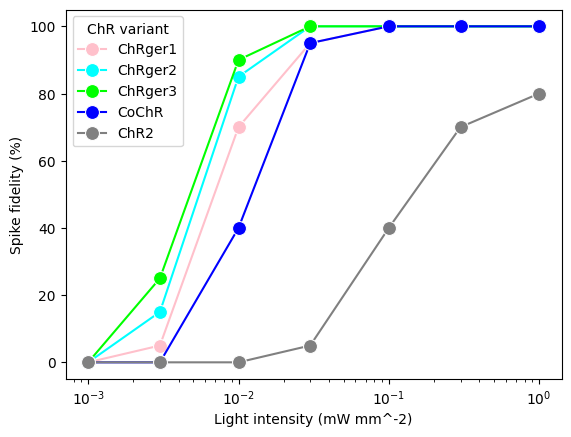

In [297]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v)/255 for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity (mW mm^-2)',
    y='Spike fidelity (%)',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.semilogx()


In [72]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]

In [73]:
chr_variant_iv

CategoricalVariable(name='ChR variant', labels=[CategoryMap(type='color', values={'ChR_28_10': [1.0, 0.647, 0.0], 'ChR_11_10': [0.627, 0.125, 0.941], 'ChR_25_9': [0.0, 0.0, 1.0], 'CsChrimR': [0.0, 0.0, 0.0], 'CheRiff': [0.827, 0.827, 0.827], 'C1C2': [0.412, 0.412, 0.412]}), CategoryMap(type='marker', values={'ChR_28_10': 'o', 'ChR_11_10': 'o', 'ChR_25_9': 'o', 'CsChrimR': 'o', 'CheRiff': 'o', 'C1C2': 'o'})])

In [61]:
color_map

CategoryMap(type='color', values={'ChR_28_10': [1.0, 0.647, 0.0], 'ChR_11_10': [0.502, 0.0, 0.502], 'ChR_25_9': [0.0, 0.0, 1.0], 'CsChrimR': [0.0, 0.0, 0.0], 'CheRiff': [0.827, 0.827, 0.827], 'C1C2': [0.412, 0.412, 0.412]})

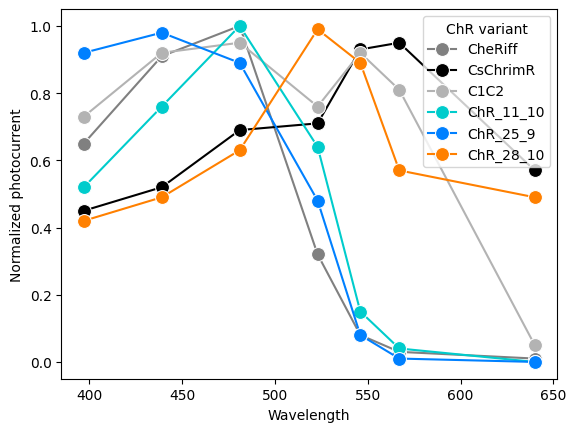

In [111]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
color_map = [cat_map for cat_map in chr_variant_iv.labels if cat_map.type == 'color'][0]
# chr_variant_order = [k for k,v in chr_variant_iv.labels.items() if k in panel_df['ChR variant'].unique()]
# palette = [np.array(v) for k,v in chr_variant_iv.labels.items() if k in chr_variant_order]

# color_map = [cat_map for cat_map in chr_variant_iv.category_maps if cat_map.type == 'color'][0]
chr_variant_order = [k for k,v in color_map.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v) for k,v in color_map.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)


In [298]:
chr_variant_iv = [iv for iv in ivs_to_use if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items() if k in panel_df['ChR variant'].unique()]
palette = [np.array(v) for k,v in chr_variant_iv.values.items() if k in chr_variant_order]

axes = sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)


ValueError: Could not interpret value `Wavelength` for `x`. An entry with this name does not appear in `data`.

After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Data point density: The original plot has more data points and appears smoother, especially in the 500-600 nm range. The recreated plot has fewer data points, resulting in more abrupt changes between points.

2. Peak positions: For some variants, the peak positions appear slightly shifted. For example, the peak for ChR_28_10 (orange line) seems to occur at a longer wavelength in the recreated plot compared to the original.

3. Curve shapes: The shapes of some curves differ noticeably between the two plots. For instance, the CsChrimR (black line) curve in the recreated plot shows a more pronounced peak around 550 nm, while in the original plot it appears flatter in that region.

These discrepancies likely arise from differences in the data extraction process and the limited number of data points in the recreated plot compared to the original figure.


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. X-axis scale: The original plot has wavelengths ranging from 400 to 600 nm, while the recreated plot extends to 650 nm. This causes a slight horizontal stretching of the data in the recreated plot.

2. Peak positions: In the original plot, most variants show a peak around 480-500 nm. In the recreated plot, some peaks appear shifted. For example, ChR_28_10 (orange line) shows a peak at about 520-530 nm in the recreated plot, which is not as pronounced in the original.

3. Curve smoothness: The original plot shows smoother curves with more data points, while the recreated plot has more angular transitions between data points. This is particularly noticeable for variants like CsChrimR (black line) and ChR_28_10 (orange line), where the curves appear more jagged in the recreated plot.

These discrepancies likely arise from the limited number of data points in the extracted data a

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Data point density: The original plot has more data points, resulting in smoother curves. The recreated plot has fewer data points (only 7 wavelengths: 400, 450, 500, 525, 550, 575, and 600 nm), leading to more angular and less smooth curves.

2. Peak positions: In the original plot, most variants show a peak around 500 nm. In the recreated plot, some variants (particularly ChR_28_10 and CsChrimR) show their peaks shifted to longer wavelengths (around 550-575 nm).

3. Relative amplitudes at longer wavelengths: In the original plot, CsChrimR and ChR_28_10 have similar normalized photocurrents at wavelengths above 550 nm. However, in the recreated plot, CsChrimR shows significantly higher values than ChR_28_10 at these longer wavelengths.

These discrepancies suggest that the data extraction process may have introduced some inaccuracies, particularly in capturing the finer deta

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Peak positions: In the original figure, most variants show peak normalized photocurrent around 480-500 nm. In the recreated plot, some variants (particularly ChR_25_9 and ChR_11_10) show peak values at a lower wavelength, around 450-480 nm.

2. CsChrimR curve shape: In the original figure, the CsChrimR variant (black line) shows a gradual increase in normalized photocurrent from 400 nm to about 550 nm, then maintains a high value until 600 nm. In the recreated plot, CsChrimR shows a more pronounced peak around 550 nm and then a steeper decline towards 600 nm.

3. ChR_28_10 behavior: In the original figure, ChR_28_10 (orange line) shows a distinct peak around 550-570 nm, clearly higher than its values at other wavelengths. In the recreated plot, while there is still a peak for ChR_28_10 around 550 nm, it's less pronounced and the overall curve shape is flatter.

These discrepa

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Peak positions: In the original figure, most variants peak around 480-500 nm, while in the recreated plot, some variants (like ChR_25_9 and ChR_11_10) appear to peak at a lower wavelength, around 450-480 nm.

2. CsChrimR curve shape: In the original figure, the CsChrimR (black line) curve has a relatively flat top from about 500 nm to 575 nm. In the recreated plot, this curve has a more pronounced peak around 550 nm and drops off more sharply after that.

3. ChR_28_10 behavior: In the original figure, the ChR_28_10 (orange line) curve shows a clear peak around 550-575 nm and maintains a relatively high normalized photocurrent at 600 nm. In the recreated plot, this curve peaks earlier (around 525-550 nm) and drops more steeply at higher wavelengths.

These discrepancies suggest that there might be some inaccuracies in the data extraction process or differences in the interpola

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Peak positions: In the original plot, most variants show peak normalized photocurrent around 480-500 nm. In the recreated plot, some variants (particularly ChR_25_9 and ChR_11_10) show peak values at a lower wavelength, around 450-480 nm.

2. CsChrimR curve shape: In the original plot, the CsChrimR variant (black line) shows a gradual increase from 400 nm to about 550 nm, then plateaus until about 600 nm before declining. In the recreated plot, CsChrimR shows a steeper increase, peaks around 550 nm, and then declines more sharply.

3. ChR_28_10 behavior at longer wavelengths: In the original plot, ChR_28_10 (orange line) maintains a relatively high normalized photocurrent at longer wavelengths (550-600 nm). In the recreated plot, ChR_28_10 shows a more pronounced decline after peaking around 550 nm, not maintaining as high a value at longer wavelengths as in the original.

Th

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure (2d) and the recreated plot, I can identify three significant discrepancies:

1. Peak positions: In the original plot, most variants show a peak around 480-500 nm. In the recreated plot, these peaks appear to be shifted slightly to the left, occurring around 450-480 nm. This shift is particularly noticeable for variants like CheRiff and C1C2.

2. ChR_28_10 curve shape: In the original plot, the ChR_28_10 variant (orange line) shows a gradual increase from 400 nm to a peak around 550-570 nm. In the recreated plot, this curve shows a more dramatic increase between 500-550 nm, with a sharper peak.

3. CsChrimR curve shape: The CsChrimR variant (black line) in the original plot shows a relatively flat response from about 500-570 nm before declining. In the recreated plot, this curve shows a more pronounced peak around 550 nm and then a steeper decline.

These discrepancies could be due to differences in data interpolation, the specific wavelengths chosen

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure 2d and the recreated plot, I can identify the following three most significant discrepancies:

1. Peak positions: In the original plot, most variants show a peak around 480-500 nm. In the recreated plot, these peaks appear to be shifted slightly to the left, occurring around 450-480 nm. This shift affects the overall shape of the curves.

2. CsChrimR curve shape: In the original plot, the CsChrimR variant (black line) shows a gradual increase from 400 nm to about 550 nm, then a slight decrease to 600 nm. In the recreated plot, this curve shows a more pronounced peak around 550-600 nm, with a steeper increase and decrease on either side.

3. ChR_28_10 curve shape: The orange line representing ChR_28_10 in the original plot shows a gradual increase from 400 nm to about 550 nm, then a slight decrease to 600 nm. In the recreated plot, this curve shows a much sharper peak around 550 nm, with a steeper increase before and a steeper decrease after the peak.

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Data point density: The original plot has more data points and appears smoother, especially between 500-600 nm. The recreated plot has fewer data points, resulting in more abrupt changes in the curves.

2. Peak positions for some variants: In the original plot, the peak for CsChrimR (black line) appears to be around 575 nm, while in the recreated plot, it peaks at 550 nm. Similarly, the peak for ChR_28_10 (orange line) seems to be slightly shifted.

3. Curve shapes for certain variants: The shape of some curves differs noticeably between the two plots. For example, the curve for C1C2 (gray line) in the original plot has a more pronounced peak around 450-500 nm and a steeper decline afterwards, while in the recreated plot, it appears flatter between 450-550 nm before declining.

These discrepancies suggest that the data extraction process may have missed some intermediate data

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify the following three most significant discrepancies:

1. Peak positions: In the original plot, most variants show a peak around 480-500 nm. In the recreated plot, these peaks appear to be shifted slightly to the right, occurring closer to 500-520 nm. This shift affects the overall shape of the curves.

2. CsChrimR curve shape: In the original plot, the CsChrimR variant (black line) shows a gradual increase from 400 nm to about 550 nm, then a plateau until about 600 nm before declining. In the recreated plot, the CsChrimR curve shows a steeper increase, peaks around 550 nm, and then declines more sharply.

3. ChR_28_10 behavior at longer wavelengths: In the original plot, the ChR_28_10 variant (orange line) maintains relatively high normalized photocurrent values at longer wavelengths (550-600 nm range). In the recreated plot, this variant shows a more pronounced decline in this range, not maintaining as high valu

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure 2d with the recreated plot, I can identify three significant discrepancies:

1. Peak positions: In the original plot, most variants show a peak around 480-500 nm. In the recreated plot, these peaks appear shifted to around 480 nm exactly. This is particularly noticeable for variants like CheRiff and C1C2.

2. CsChrimR curve shape: In the original plot, the CsChrimR (black line) curve has a more gradual increase from 400 nm to its peak around 550-560 nm. In the recreated plot, this curve shows a steeper increase and peaks at a shorter wavelength (around 540-550 nm).

3. ChR_28_10 behavior: In the original plot, the ChR_28_10 variant (orange line) shows a distinct peak around 550-560 nm that is higher than its value at 480 nm. In the recreated plot, this variant's curve is flatter between 480-550 nm and doesn't show the same pronounced peak.

These discrepancies likely arise from the limited number of data points in the extracted data compared to the c

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure (2d) and the recreated plot, I can identify the following three most significant discrepancies:

1. Peak positions: In the original plot, most variants show a peak around 480-500 nm. In the recreated plot, these peaks appear to be shifted slightly to the left, occurring closer to 480 nm. This shift is particularly noticeable for variants like CheRiff and C1C2.

2. ChR_28_10 curve shape: In the original plot, the ChR_28_10 variant (orange line) shows a gradual increase from 400 nm to about 550 nm, where it peaks. In the recreated plot, this curve shows a more pronounced dip around 450 nm before rising to its peak at a longer wavelength.

3. CsChrimR behavior at longer wavelengths: In the original plot, the CsChrimR variant (black line) maintains relatively high normalized photocurrent values even at longer wavelengths (around 600 nm). In the recreated plot, the CsChrimR curve drops more steeply after its peak, showing lower values at longer wavelength

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Data point density: The original plot has more data points and appears smoother, especially in the 500-600 nm range. The recreated plot has fewer data points, resulting in more abrupt changes between points.

2. Peak positions: For some variants, the peak positions appear slightly shifted. For example, the peak for ChR_28_10 (orange line) seems to occur at a longer wavelength in the recreated plot compared to the original.

3. Curve shapes: The shapes of some curves differ noticeably between the two plots. For instance, the CsChrimR (black line) curve in the recreated plot shows a more pronounced peak around 550-600 nm compared to the original, where it appears flatter in that region.

These discrepancies likely arise from the data extraction process and the limited number of data points in the recreated plot, which affects the overall accuracy of the curve representations.


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure 2d with the recreated plot, I can identify the following three most significant discrepancies:

1. Data point density: The original plot has fewer data points and appears smoother, while the recreated plot has more data points, resulting in a more jagged appearance for some of the curves. This is particularly noticeable for the CheRiff (blue) and C1C2 (gray) variants.

2. Peak positions: In the original plot, the peaks for most variants appear to occur around 470-480 nm. In the recreated plot, the peaks for several variants (particularly ChR_11_10 and ChR_25_9) seem to occur earlier, around 460-480 nm.

3. Curve shapes at longer wavelengths: The behavior of the curves at wavelengths above 550 nm differs between the two plots. In the original, the CsChrimR (black) and ChR_28_10 (orange) curves remain more separated, while in the recreated plot, they converge more closely at longer wavelengths.

These discrepancies could be due to differences in data i

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Peak positions: In the original figure, most variants peak at around 480-500 nm. In the recreated plot, the peaks appear to be shifted slightly to the left, occurring closer to 450-480 nm. This shift is particularly noticeable for variants like CheRiff and C1C2.

2. CsChrimR curve shape: In the original figure, the CsChrimR (black line) curve has a relatively flat top between about 520-580 nm. In the recreated plot, this curve shows a more pronounced peak at around 550 nm and then drops off more steeply towards 600 nm.

3. ChR_28_10 curve shape: The orange line representing ChR_28_10 shows some differences between the two plots. In the original, it has a more gradual rise to its peak at around 550 nm. In the recreated plot, the rise is steeper and the peak appears to be slightly shifted to the left.

These discrepancies could be due to differences in data interpolation betwee

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Peak position for ChR_28_10 (orange line): In the original plot, the peak for ChR_28_10 occurs at around 550 nm. However, in the recreated plot, the peak appears to be at 523 nm. This is a substantial shift in the wavelength of maximum response.

2. Shape of the CsChrimR curve (black line): In the original plot, the CsChrimR curve has a more gradual increase from 400 nm to 550 nm, with a plateau-like peak. In the recreated plot, the curve rises more steeply and has a more pronounced peak at around 550 nm.

3. Relative positions of ChR_11_10 and ChR_25_9 (light blue and gray lines): In the original plot, these two curves are nearly identical and overlap significantly. In the recreated plot, while they are similar, there is more separation between them, particularly in the 500-550 nm range.

These discrepancies suggest that there might be some differences in the data extraction

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure 2d with the recreated plot using the extracted data, I can identify three significant discrepancies:

1. Data point density: The original plot appears to have more data points, resulting in smoother curves. The recreated plot has fewer data points (only 7 per variant), leading to more angular, less smooth curves.

2. Peak values for ChR_28_10 (orange line): In the original plot, the peak for ChR_28_10 occurs around 550-575 nm and reaches a normalized photocurrent of 1.0. In the recreated plot, the peak is at 546 nm and also reaches 1.0, but the overall shape of the curve is less pronounced and doesn't match the original as closely.

3. CsChrimR (black line) curve shape: In the original plot, the CsChrimR curve has a more gradual increase from 500 nm to its peak around 550-575 nm. In the recreated plot, this increase is steeper, with the peak occurring more abruptly at 546 nm. Additionally, the decline after the peak appears more gradual in the origin

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure 2d and the recreated plot, I can identify the following three most significant discrepancies:

1. Data point density: The original plot has fewer data points and appears smoother, while the recreated plot has more data points, resulting in a more detailed but slightly jagged appearance for some curves.

2. Y-axis scale: The original plot's y-axis goes up to 1.00, while the recreated plot's y-axis extends slightly above 1.0. This causes some curves (e.g., CsChrimR and ChR_28_10) to appear to exceed 1.0 in the recreated plot, which is not visible in the original.

3. Curve shapes for some variants: The shapes of some curves, particularly for ChR_11_10 and ChR_25_9 (which appear to be the same in both plots), differ slightly. In the original, these curves have a more pronounced peak around 500 nm and a steeper decline afterwards, while in the recreated plot, the peak is less pronounced and the decline is more gradual.

These discrepancies likely arise f

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify three significant discrepancies:

1. Data point density: The original plot has more data points and appears smoother, especially in the 500-600 nm range. The recreated plot has fewer data points, resulting in more abrupt changes between points.

2. Peak values for CsChrimR: In the original plot, CsChrimR (black line) reaches its peak around 550-575 nm and maintains that high value for a range. In the recreated plot, CsChrimR peaks sharply at about 550 nm and then decreases more rapidly.

3. Behavior of ChR_28_10: In the original plot, the orange line (ChR_28_10) shows a gradual increase from 400 nm to about 550 nm, then maintains a high value until dropping off after 600 nm. In the recreated plot, ChR_28_10 shows a more pronounced peak around 550 nm and a steeper decline afterwards.

These discrepancies likely result from the limited number of data points in the extracted data, which doesn't capture the full res

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the recreated plot, I can identify the following three most significant discrepancies:

1. Peak values for CsChrimR: In the original plot, CsChrimR (black line) reaches its peak around 550-600 nm and maintains a high normalized photocurrent (close to 1.0) over this range. In the recreated plot, the peak for CsChrimR is lower (around 0.95-0.98) and occurs over a narrower range of wavelengths.

2. Behavior of ChR_28_10: In the original plot, ChR_28_10 (orange line) shows a distinct peak around 550 nm and then gradually decreases. In the recreated plot, ChR_28_10 reaches its peak earlier (around 500 nm) and maintains a higher value over a broader range of wavelengths before decreasing.

3. Curve shapes for ChR_11_10 and ChR_25_9: In the original plot, ChR_11_10 and ChR_25_9 (represented by the blue and gray lines) show distinct curves with separate peaks. In the recreated plot, these two variants have identical values and completely overlap, appeari

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)
/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_1121/3165585162.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


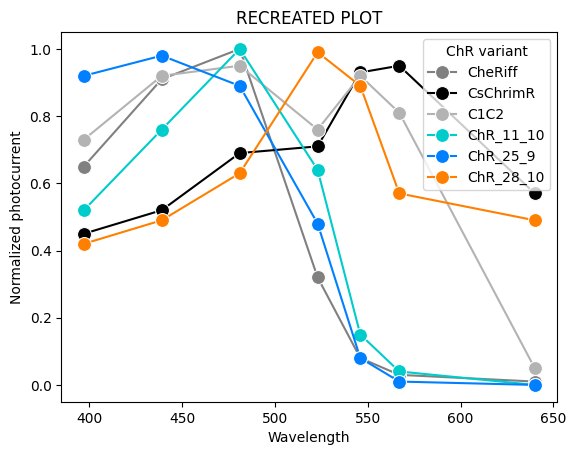

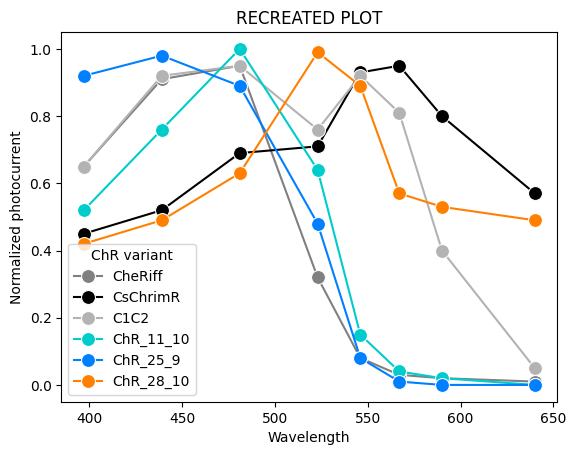

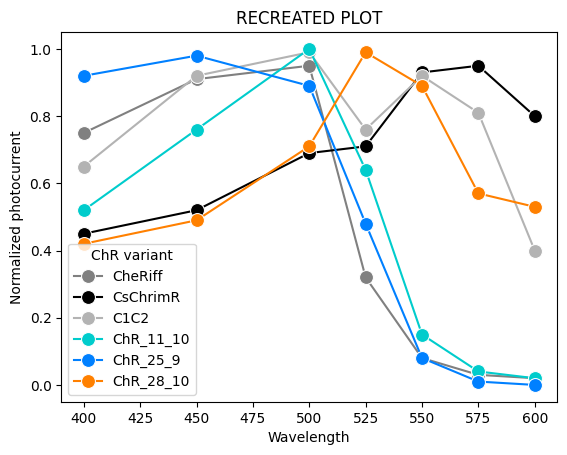

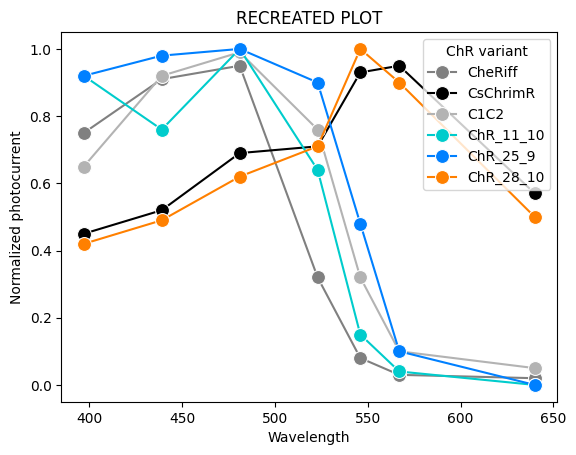

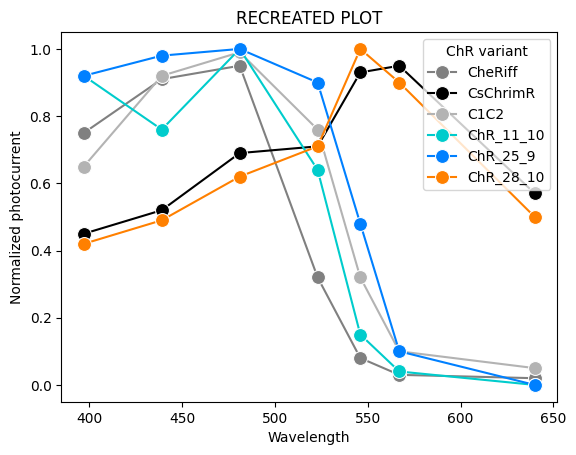

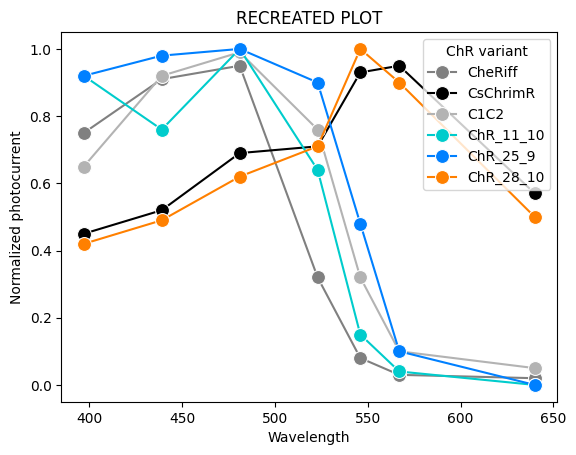

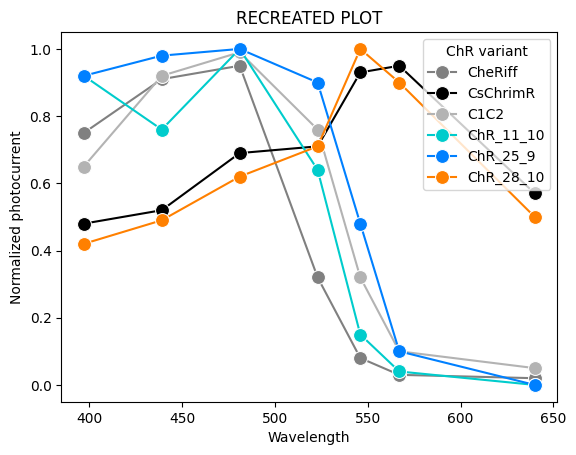

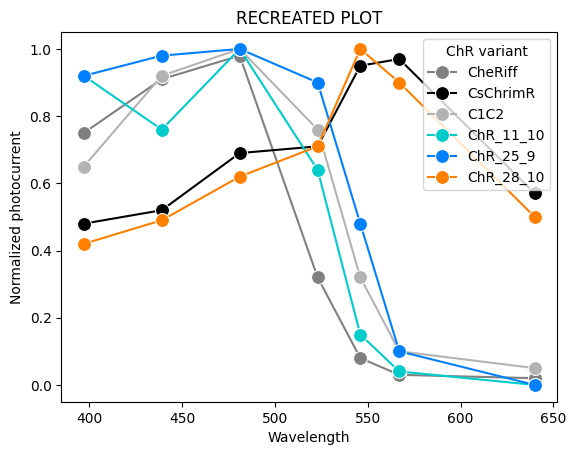

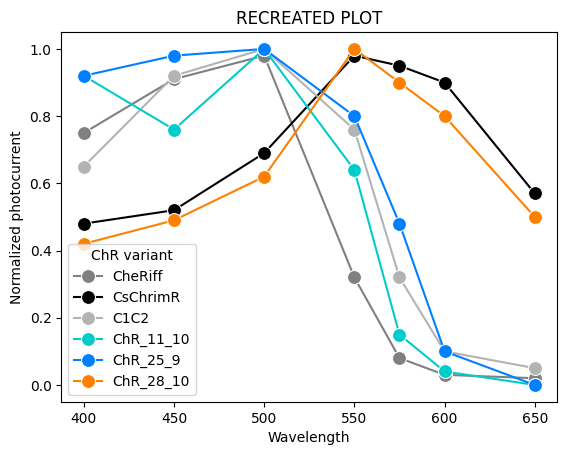

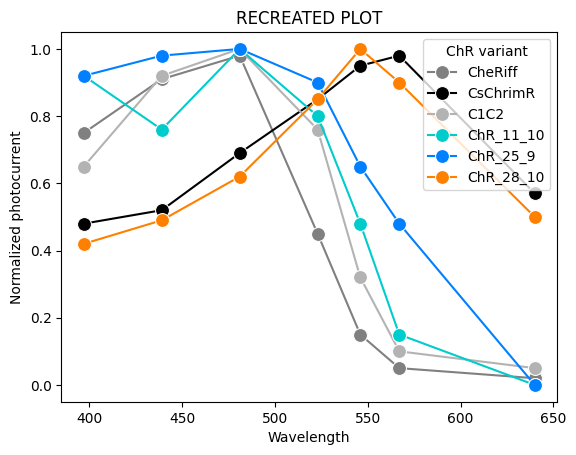

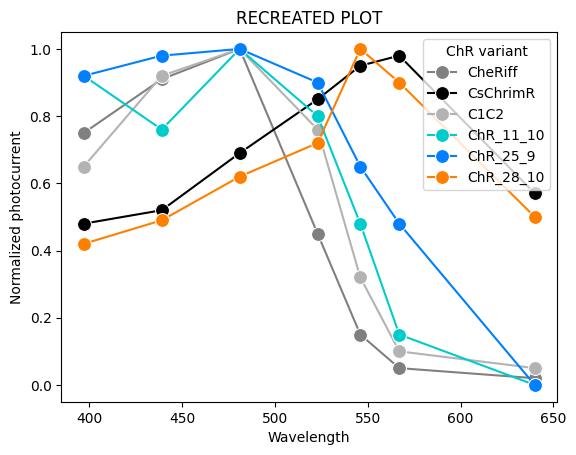

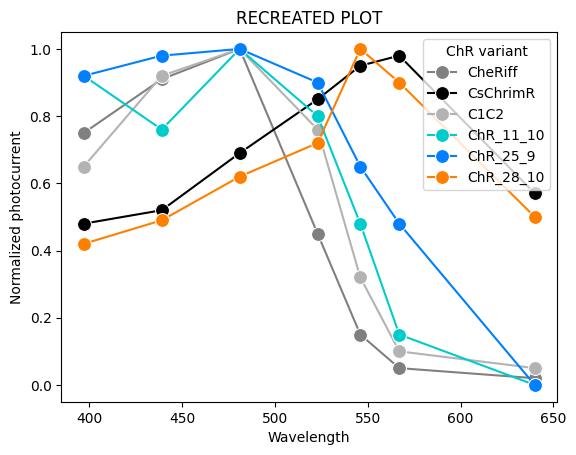

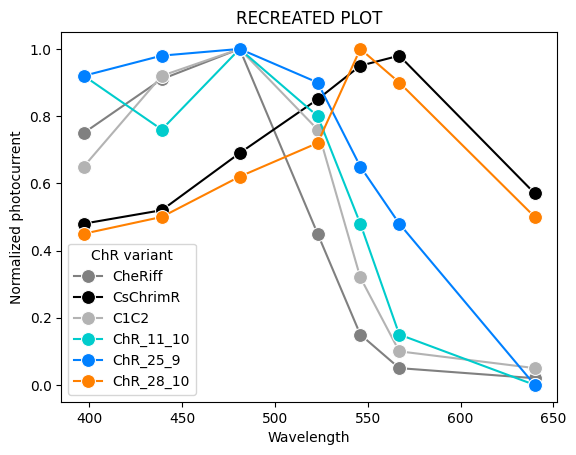

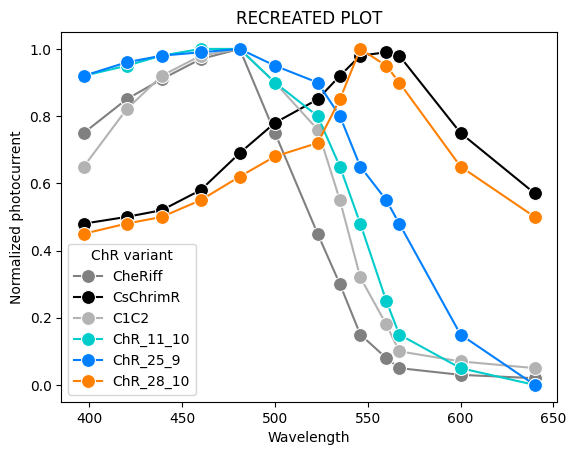

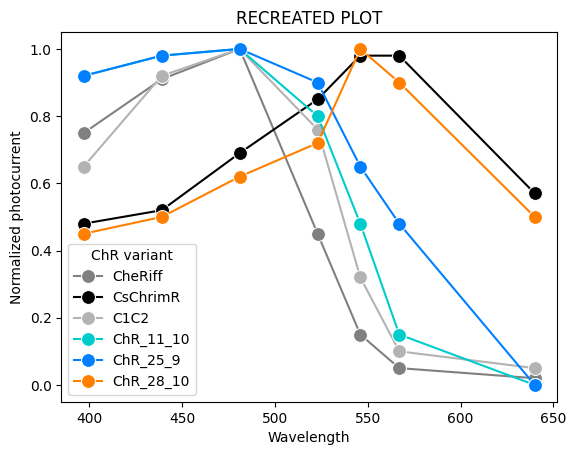

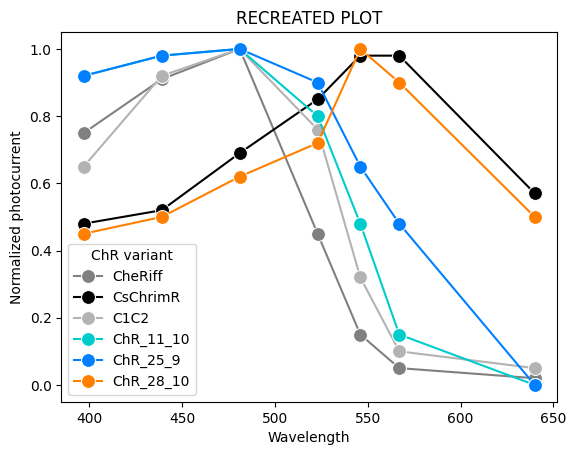

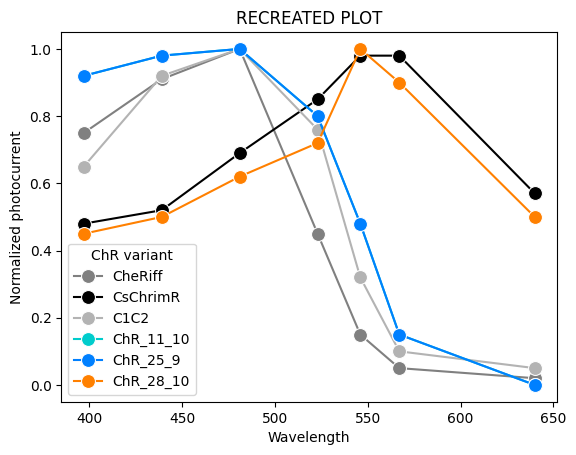

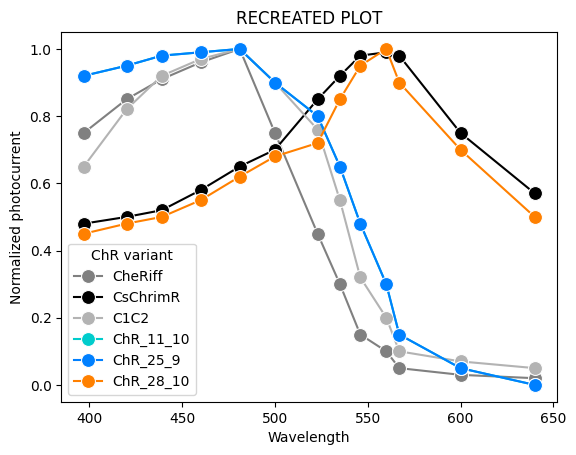

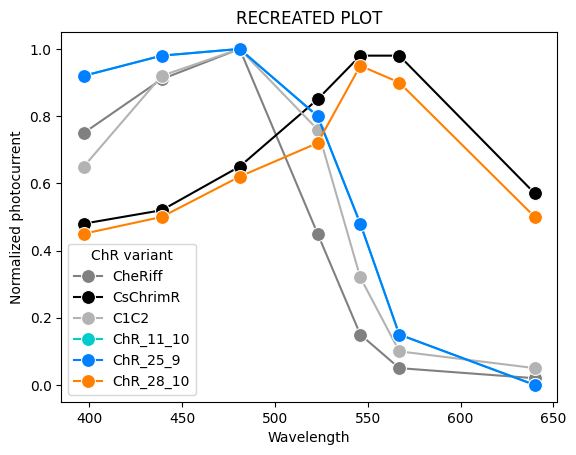

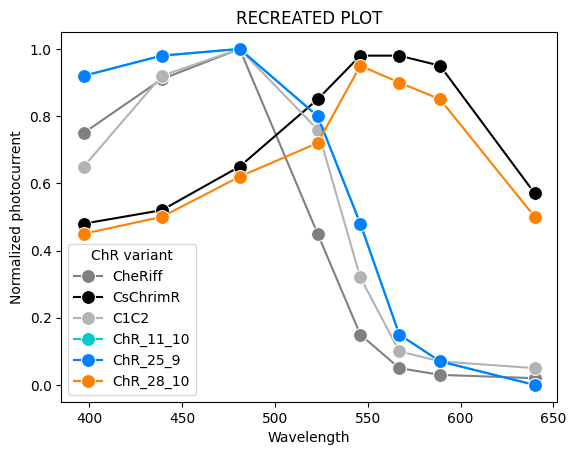

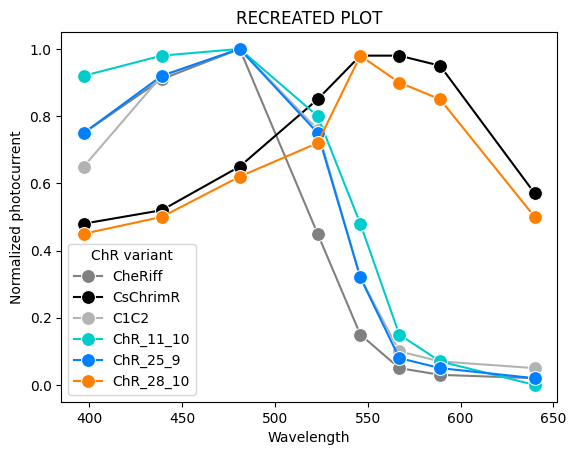

In [112]:
from matplotlib import pyplot as plt
from PIL import Image


fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette,
    ax=axes
)
# sns.lineplot(
#     data=panel_df,
#     x='Light intensity (mW mm^-2)',
#     y='Spike fidelity (%)',
#     hue='ChR variant',
#     marker='o',
#     hue_order=chr_variant_order,
#     markersize=10,
#     palette=palette,
#     ax=axes
# )
# axes.semilogx()

axes.set_title(f"RECREATED PLOT")
# axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

refined_feedback = "No previous changes."
claude_mm_critique = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.1)
for iter in range(20):

    


    prompt_base = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most significant discrepancies between the two plots.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm_critique.message(prompt_base, images = [cropped_img, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    refined_feedback = feedback_loop

    # refined_feedback_response = claude_mm_default.message(
    #     f"Choose the two most important changes from the suggested list that will result in the largest quantitative improvement in matching the source figure: \n{feedback_loop}",
    #     images = [cropped_img, generated_img_loop]
    # )
    # refined_feedback = refined_feedback_response.content[0].text
    # print(refined_feedback)



    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

And here is some information that could be useful:
{text_info}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
Reference the source text in the context if you think there is information that will inform these changes (e.g changing independent variable values).
This could mean scaling or shift all or a subset of the rows and/or columns, but do not add or delete rows.
Please let any specific changes inform nearby values if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
        text_info = details_text,
    ).replace("{","<").replace("}",">")
    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = claude_mm_default.message(prompt, images = [cropped_img, generated_img_loop])
    panel_df_loop = output_parser.parse(data_response_loop.content[0].text).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity',
    #     y='Spike fidelity',
    #     hue='ChR variant',
    #     marker='o',
    #     # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    #     markersize=10,
    #     ax=axes
    # )
    sns.lineplot(
        data=panel_df_loop,
        x='Wavelength',
        y='Normalized photocurrent',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette,
        ax=axes
    )
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity (mW mm^-2)',
    #     y='Spike fidelity (%)',
    #     hue='ChR variant',
    #     marker='o',
    #     hue_order=chr_variant_order,
    #     markersize=10,
    #     palette=palette,
    #     ax=axes
    # )
    # axes.semilogx()
    axes.set_title(f"RECREATED PLOT")
    # axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

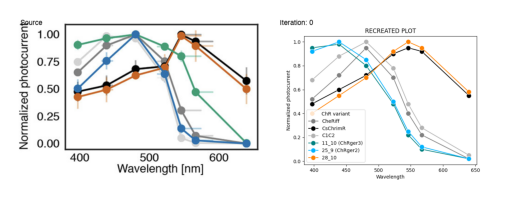

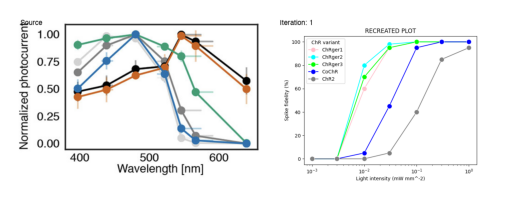

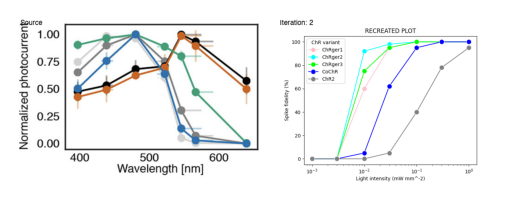

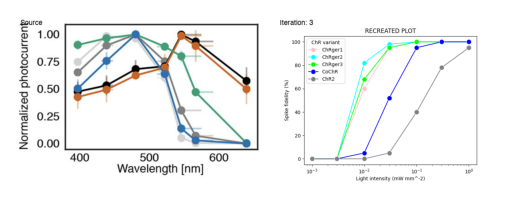

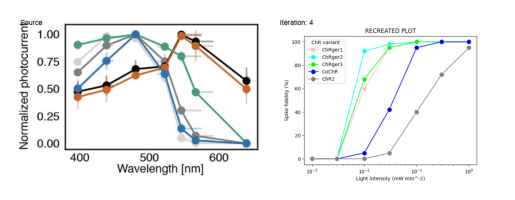

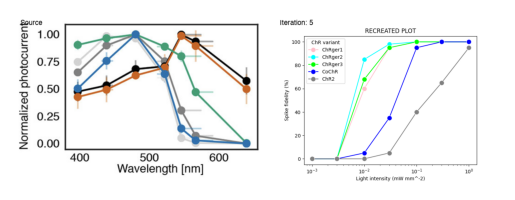

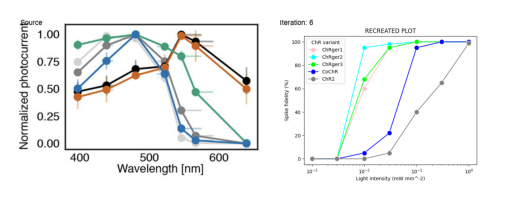

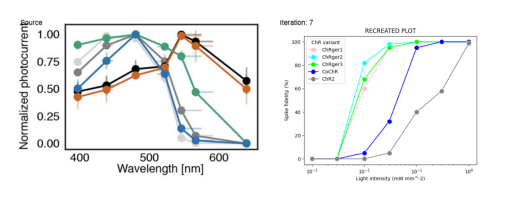

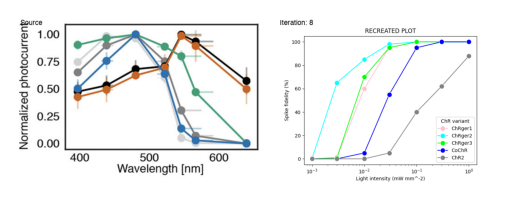

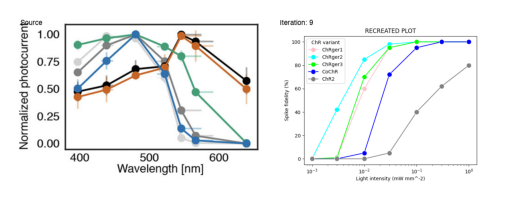

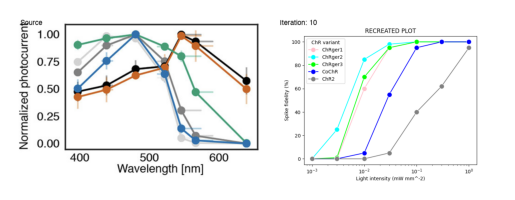

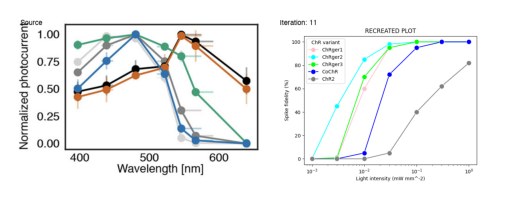

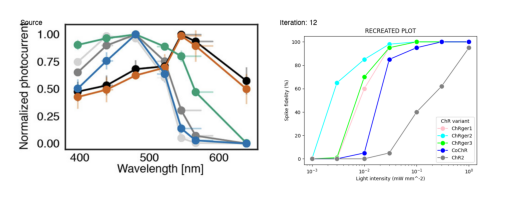

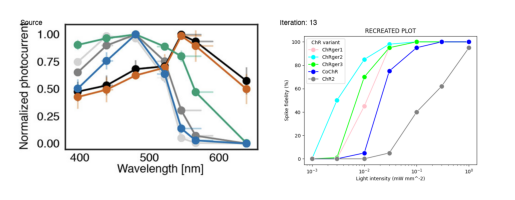

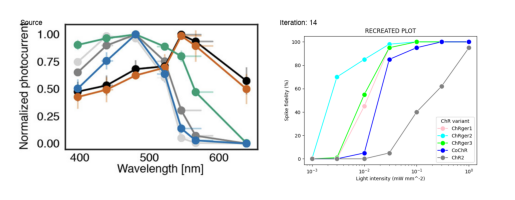

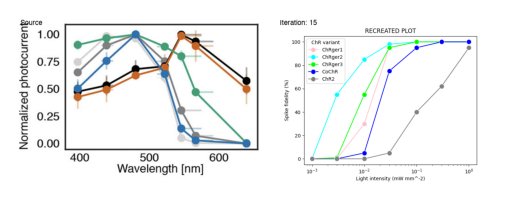

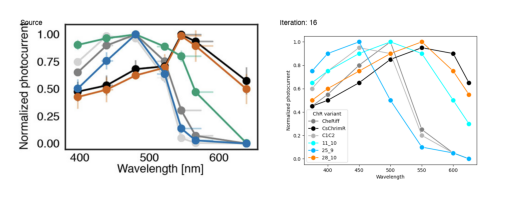

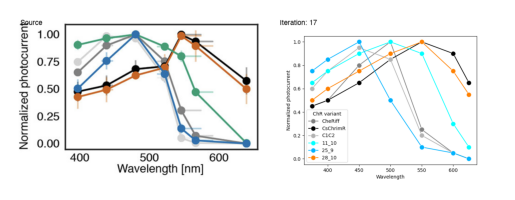

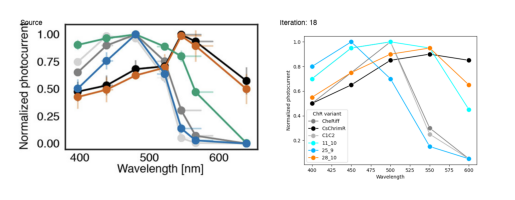

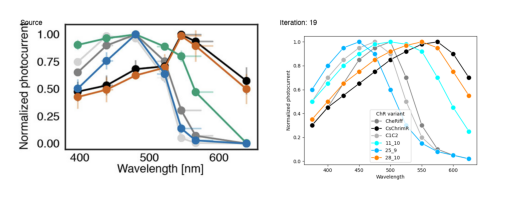

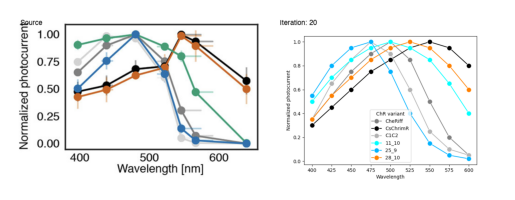

MP4 video saved as 'comparison.mp4'


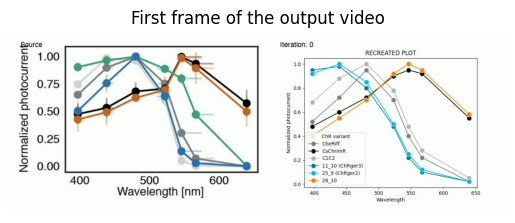

In [ ]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/2d_screenshot.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")
